In [1]:
import matplotlib.pyplot as plt
import numpy as np

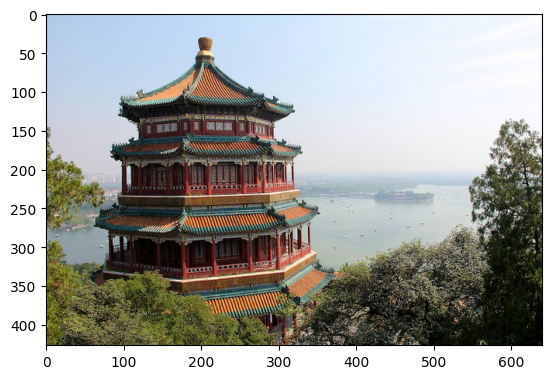

In [2]:
from sklearn.datasets import load_sample_images


dataset = load_sample_images()
rgb1 = dataset.images[0]
rgb2 = dataset.images[1]
plt.imshow(rgb1)

In [3]:
rgb1 = rgb1 / 255
rgb2 = rgb2 / 255

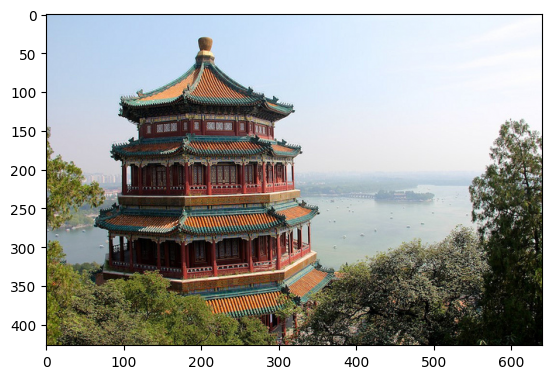

In [4]:
plt.imshow(rgb1)

In [5]:
np.prod(rgb1.shape)

819840

In [6]:
from skimage.color import lab2rgb, rgb2lab

In [7]:
def color_shift(image: np.ndarray, channel: str, value: int=3):
    lab = rgb2lab(image).copy()
    assert channel in ['a', 'b']
    if channel == 'a':
        lab[:, :, 1] = np.clip(lab[:, :, 1] + value, -100, 100)
    else:
        lab[:, :, 2] = np.clip(lab[:, :, 2] + value, -100, 100)
    return lab2rgb(lab)

In [8]:
rgb1_noisy = np.clip(rgb1 + np.random.normal(loc=0, scale=0.02, size=np.prod(rgb1.shape)).reshape(rgb1.shape), 0, 1)
plt.imshow(rgb1_noisy)

0.0012234421423091035

In [9]:
from skimage.color import deltaE_ciede2000, deltaE_cie76, rgb2lab, lab2rgb

def mse_rgb(rgb1, rgb2, mask: bool=False):
    assert rgb1.shape == rgb2.shape
    assert isinstance(rgb1, np.ndarray)
    assert isinstance(rgb2, np.ndarray)

    mse_map = (rgb1[:, :, 0] - rgb2[:, :, 0]) ** 2 + \
                (rgb1[:, :, 1] - rgb2[:, :, 1]) ** 2 + \
                (rgb1[:, :, 2] - rgb2[:, :, 2]) ** 2
    if mask:
        return mse_map, mse_map.mean()
    
    return mse_map.mean()

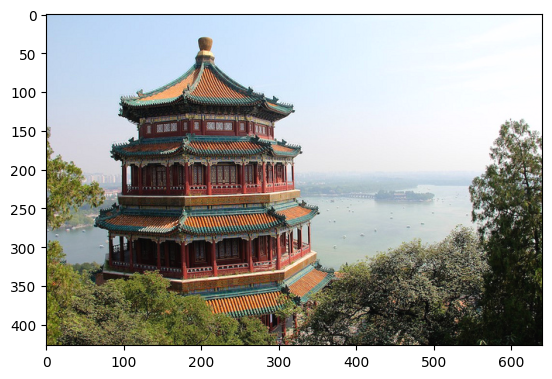

In [10]:
lab1 = rgb2lab(rgb1)
lab1_noisy = rgb2lab(rgb2)

def change_brightness(image: np.ndarray, value: int):
    lab = rgb2lab(image).copy()
    lab[:, :, 0] = np.clip(lab[:, :, 0] + value, 0, 100)
    return lab2rgb(lab)

rgb1_bright = change_brightness(rgb1, 2)
plt.imshow(rgb1_bright)

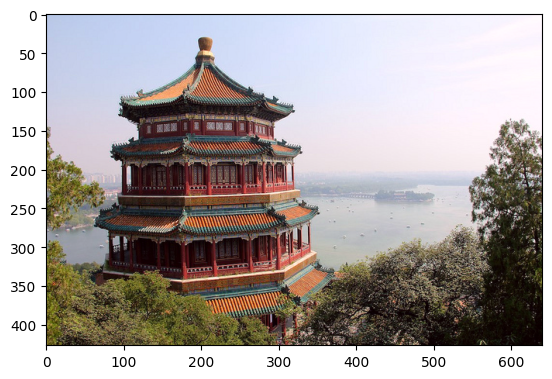

In [11]:
rgb1_shifted = color_shift(rgb1, 'a', 4)
plt.imshow(rgb1_shifted)

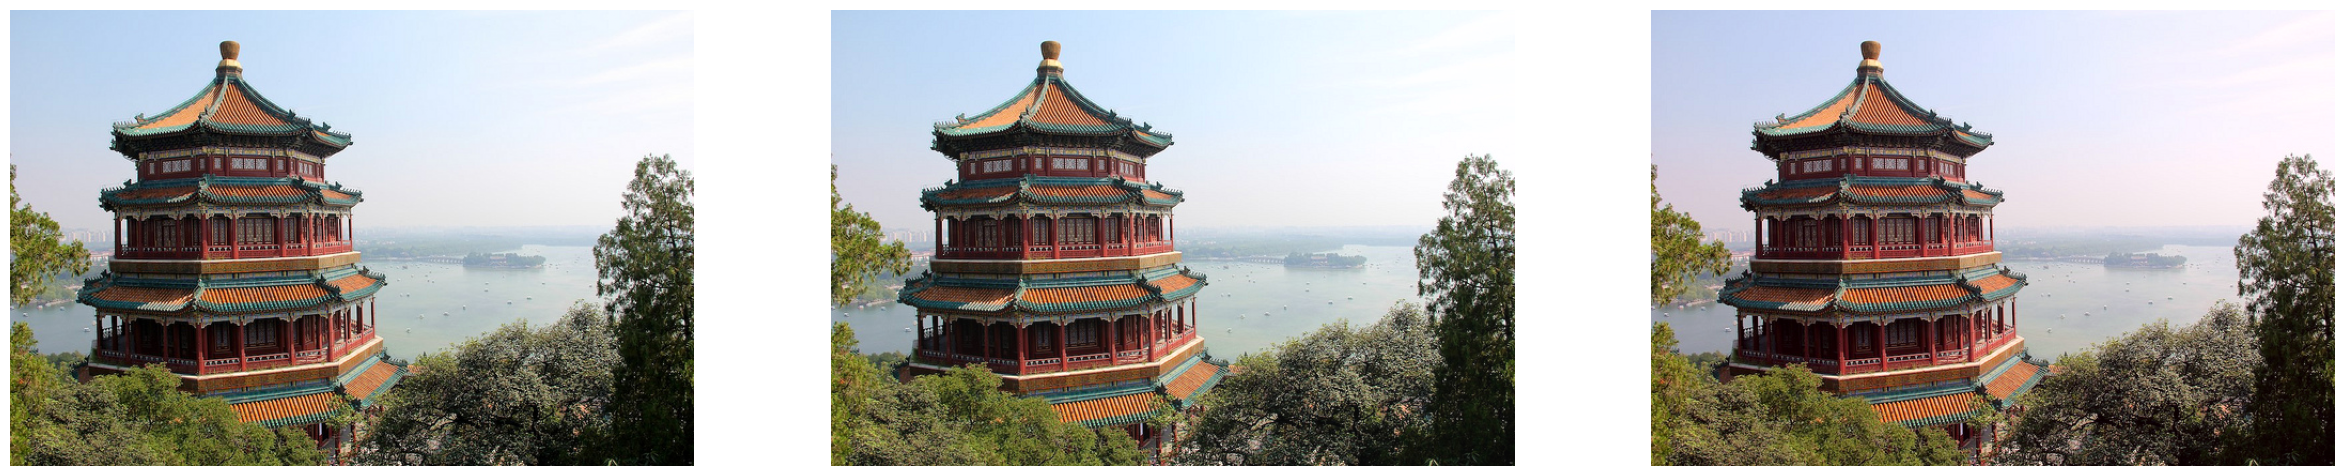

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
axes[0].imshow(rgb1)
axes[1].imshow(rgb1_bright)
axes[2].imshow(rgb1_shifted)

for ax in axes:
    ax.axis('off')

In [13]:
mse_rgb(rgb1, rgb1_bright), mse_rgb(rgb1, rgb1_shifted)

(0.0012234421423091035, 0.0009255850709556313)

In [14]:
deltaE_cie76(rgb2lab(rgb1), rgb2lab(rgb1_bright)).mean(), deltaE_cie76(rgb2lab(rgb1), rgb2lab(rgb1_shifted)).mean()

(2.1511545510484367, 3.955657425112855)

In [15]:
deltaE_ciede2000(rgb2lab(rgb1), rgb2lab(rgb1_bright)).mean(), deltaE_ciede2000(rgb2lab(rgb1), rgb2lab(rgb1_shifted)).mean()

(1.604809990974987, 4.57365810346965)

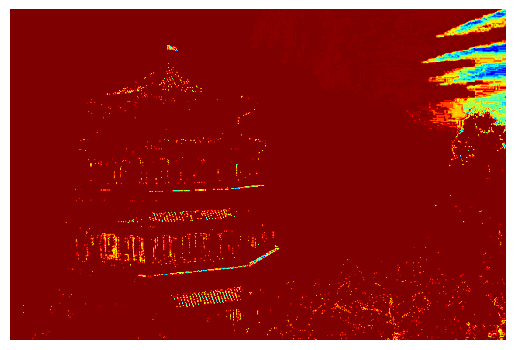

In [16]:
plt.imshow(deltaE_cie76(rgb2lab(rgb1), rgb2lab(rgb1_shifted)), cmap='jet')
plt.axis('off')
plt.show()

In [17]:
plt.imshow(deltaE_cie76(rgb2lab(rgb1), rgb2lab(rgb1_bright)), cmap='jet')
plt.axis('off')
plt.show()

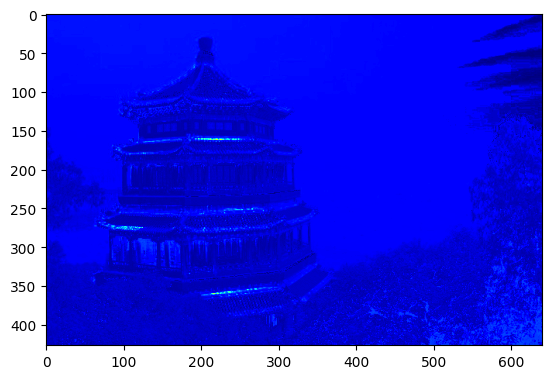

In [18]:
plt.imshow(mse_rgb(rgb1, rgb1_shifted, mask=True)[0], cmap='jet')

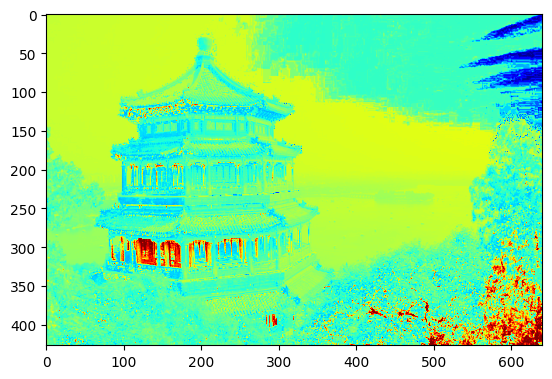

In [19]:
plt.imshow(mse_rgb(rgb1, rgb1_bright, mask=True)[0], cmap='jet')

# Noise comparison

The most difference in the structural component. Let's square it. Comparison with entropy.

In [20]:
from skimage.metrics import structural_similarity as ssim

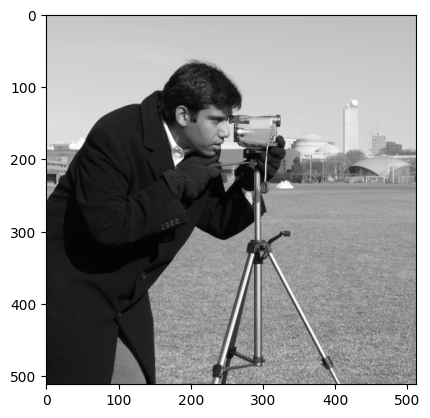

In [21]:
import skimage
import matplotlib.pyplot as plt

original_image = skimage.data.camera()
plt.imshow(original_image, cmap='gray')

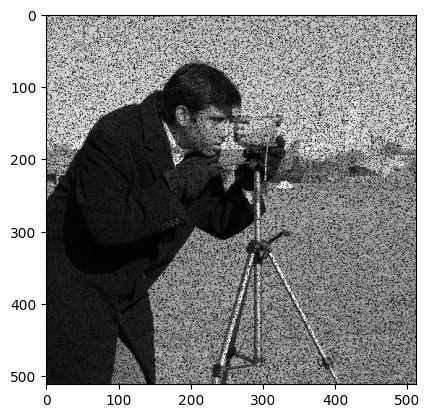

In [22]:
import numpy as np
noise_level = 0.1
noisy_image = np.copy(original_image)
salt_pepper = np.random.rand(*original_image.shape) < noise_level
noisy_image[salt_pepper] = 0
salt_pepper = np.random.rand(*original_image.shape) < noise_level
noisy_image[salt_pepper] = 1
plt.imshow(noisy_image, cmap='gray')

In [23]:
def add_noise(original_image, value):
    return (np.clip(original_image / 255 + np.random.normal(loc=0, scale=value, size=np.prod(original_image.shape)).reshape(original_image.shape), 0, 1) * 255).astype(np.uint8)

In [24]:
import cv2
def calculate_ssim(img1, img2,
                   alpha: float=1.,
                   beta: float=1.,
                   gamma: float=1.,
                   full: bool=False,
                   components: bool=False):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2
    C3 = C2 / 2
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())
    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1 ** 2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2 ** 2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma1_sq = np.where(sigma1_sq < 0, 0., sigma1_sq)
    sigma2_sq = np.where(sigma2_sq < 0, 0., sigma2_sq)
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    l = (2 * mu1_mu2 + C1) / (mu1_sq + mu2_sq + C1)
    c = (2 * np.sqrt(sigma1_sq) * np.sqrt(sigma2_sq) + C2) / (sigma1_sq + sigma2_sq + C2)
    s = (sigma12 + C3) / (np.sqrt(sigma1_sq) * np.sqrt(sigma2_sq) + C3)

    ssim_map = np.power(l, alpha) * np.power(c, beta) * np.power(s, gamma)
    if full:
        return ssim_map 
    if components:
        return l.mean(), c.mean(), s.mean()
    return ssim_map.mean()

In [25]:
import numpy as np
import skimage.measure
from skimage.color import rgb2gray

def calculate_entropy(image1, image2):
    # Convert the images to grayscale
    if len(image1.shape) > 2:
        image1 = skimage.color.rgb2gray(image1)
    if len(image2.shape) > 2:
        image2 = skimage.color.rgb2gray(image2)

    # Calculate the entropy of the images
    entropy1 = skimage.measure.shannon_entropy(image1)
    entropy2 = skimage.measure.shannon_entropy(image2)

    # Calculate the entropy difference
    entropy_diff = np.abs(entropy1 - entropy2)

    return entropy_diff

In [26]:
calculate_entropy(original_image, noisy_image)

0.4829879106585677

In [27]:
def calculate_singular_value_difference(image1, image2):
    # Convert the images to grayscale
    if len(image1.shape) > 2:
        image1 = np.mean(image1, axis=2)
    if len(image2.shape) > 2:
        image2 = np.mean(image2, axis=2)

    # Calculate the singular value decomposition of the images
    _, singular_values1, _ = np.linalg.svd(image1)
    _, singular_values2, _ = np.linalg.svd(image2)

    # Calculate the difference of the maximum singular values
    max_singular_value_diff = np.abs(np.max(singular_values1) - np.max(singular_values2))

    return max_singular_value_diff


In [28]:
import numpy as np
from scipy.ndimage import convolve

def calculate_total_variation_difference(image1, image2):
    # Convert the images to grayscale
    if len(image1.shape) > 2:
        image1 = np.mean(image1, axis=2)
    if len(image2.shape) > 2:
        image2 = np.mean(image2, axis=2)

    # Define the horizontal and vertical gradient filters
    gradient_x = np.array([[0, 0, 0], [-1, 1, 0], [0, 0, 0]])
    gradient_y = np.array([[0, -1, 0], [0, 1, 0], [0, 0, 0]])

    # Compute the gradient for each image
    gradient1_x = convolve(image1, gradient_x)
    gradient1_y = convolve(image1, gradient_y)
    gradient2_x = convolve(image2, gradient_x)
    gradient2_y = convolve(image2, gradient_y)

    # Calculate the total variation of each image
    total_variation1 = np.mean(np.sqrt(gradient1_x**2 + gradient1_y**2))
    total_variation2 = np.mean(np.sqrt(gradient2_x**2 + gradient2_y**2))

    # Calculate the difference of the total variations
    total_variation_diff = np.abs(total_variation1 - total_variation2)

    return total_variation_diff


In [29]:
import numpy as np
from scipy.ndimage import gaussian_filter

def calculate_ms_ssim(image1, image2, sigma=1.5, weights=None):
    # Convert the images to grayscale
    if len(image1.shape) > 2:
        image1 = np.mean(image1, axis=2)
    if len(image2.shape) > 2:
        image2 = np.mean(image2, axis=2)

    # Define the weights for different scales
    if weights is None:
        weights = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]

    # Initialize the variables for the MS-SSIM calculation
    mssim = np.array([])
    mcs = np.array([])

    for i, weight in enumerate(weights):
        # Apply Gaussian filter to images
        blurred1 = gaussian_filter(image1, sigma=(sigma, sigma))
        blurred2 = gaussian_filter(image2, sigma=(sigma, sigma))

        # Calculate the local mean, variance, and covariance
        mu1 = blurred1
        mu2 = blurred2
        sigma1_sq = gaussian_filter(image1**2, sigma=(sigma, sigma)) - mu1**2
        sigma2_sq = gaussian_filter(image2**2, sigma=(sigma, sigma)) - mu2**2
        sigma12 = gaussian_filter(image1 * image2, sigma=(sigma, sigma)) - mu1 * mu2

        # Calculate the luminance and contrast comparison terms
        luminance = (2 * mu1 * mu2 + weight) / (mu1**2 + mu2**2 + weight)
        contrast = (2 * sigma12 + weight) / (sigma1_sq + sigma2_sq + weight)

        # Calculate the structure comparison term
        structural = (sigma12 + weight) / (np.sqrt(sigma1_sq) * np.sqrt(sigma2_sq) + weight)

        # Calculate the MS-SSIM at this scale
        mssim = np.append(mssim, np.mean(luminance * contrast * structural))
        mcs = np.append(mcs, np.mean(contrast))

        # Downsample the images for the next scale
        image1 = image1[::2, ::2]
        image2 = image2[::2, ::2]

    # Calculate the MS-SSIM index
    ms_ssim = np.prod(mcs[:-1] ** weights[:-1]) * (mssim[-1] ** weights[-1])

    return ms_ssim


In [30]:
calculate_ms_ssim(original_image, noisy_image)

6.441157011156429

In [31]:
import numpy as np

calculate_ssim_sq = lambda img1, img2: calculate_ssim(img1, img2, gamma=2.).mean()


# noise_levels = [0.01, 0.1, 0.2, 0.5]
noise_levels = [2, 1, 0.6, 0.3, 0.1, 0.05, 0.001]
# noise_levels = np.linspace(1, 0.01, 10)


ssims_g = []
ssims_g_sq = []
ssims_sp = []
ssims_sp_sq = []
entropies_g = []
entropies_sp = []
l2_norms_g = []
l2_norms_sp = []
tv_g = []
tv_sp = []
mssim_g = []
mssim_sp = []


noisy_images_g = []
noisy_images_sp = []
for noise_level in noise_levels:
    noisy_image = add_noise(original_image, noise_level)
    ssims_g.append(calculate_ssim(original_image, noisy_image).mean())
    ssims_g_sq.append(calculate_ssim_sq(original_image, noisy_image))
    entropies_g.append(calculate_entropy(original_image, noisy_image))
    l2_norms_g.append(calculate_singular_value_difference(original_image, noisy_image))
    tv_g.append(calculate_total_variation_difference(original_image, noisy_image))
    mssim_g.append(calculate_ms_ssim(original_image, noisy_image))
    noisy_images_g.append(noisy_image)
    # Salt-and-pepper noise example
    noisy_image = np.copy(original_image)
    salt_pepper = np.random.rand(*original_image.shape) < noise_level / 2.3
    noisy_image[salt_pepper] = 0
    salt_pepper = np.random.rand(*original_image.shape) < noise_level / 2.3
    noisy_image[salt_pepper] = 1

    ssims_sp.append(calculate_ssim(original_image, noisy_image).mean())
    ssims_sp_sq.append(calculate_ssim_sq(original_image, noisy_image))
    entropies_sp.append(calculate_entropy(original_image, noisy_image))
    l2_norms_sp.append(calculate_singular_value_difference(original_image, noisy_image))
    tv_sp.append(calculate_total_variation_difference(original_image, noisy_image))
    mssim_sp.append(calculate_ms_ssim(original_image, noisy_image))
    noisy_images_sp.append(noisy_image)

In [32]:
num_images = len(noisy_images_g)

In [33]:
num_images

7

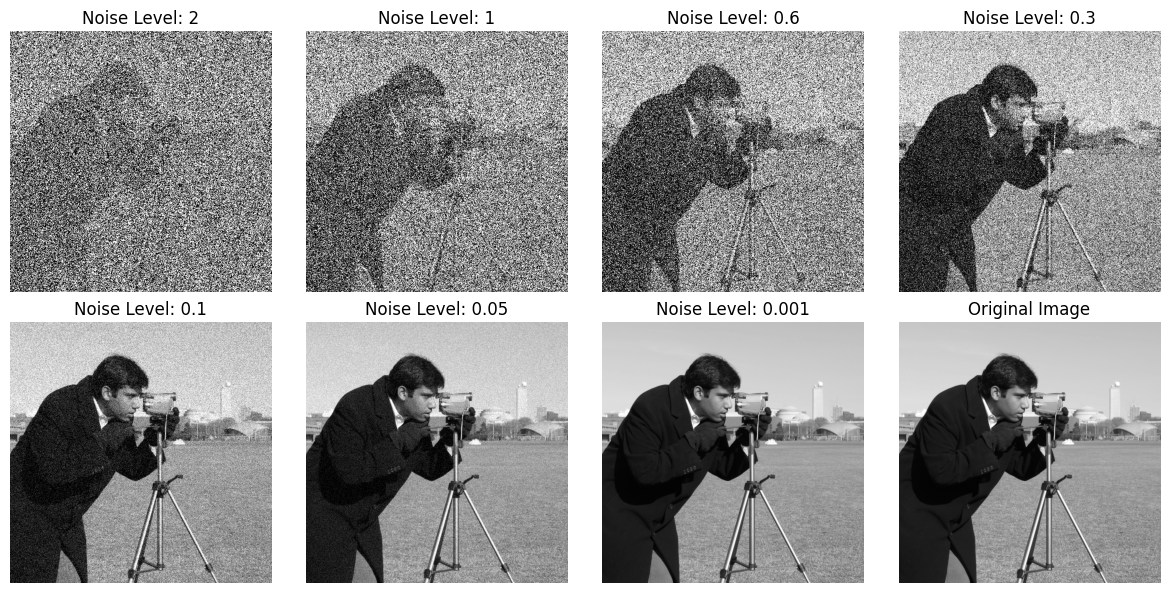

In [34]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Iterate over the noisy images and plot them in the subplots
for i in range(num_images):
    # Determine the subplot position based on the row and column
    row = i // 4
    col = i % 4
    
    # Plot the noisy image in the corresponding subplot
    axes[row, col].imshow(noisy_images_g[i], cmap='gray')
    axes[row, col].set_title(f"Noise Level: {noise_levels[i]}")
    axes[row, col].axis('off')


axes[-1, -1].imshow(original_image, cmap="gray")
axes[-1, -1].set_title("Original Image")
axes[-1, -1].axis('off')
# Adjust the spacing between subplots and display the figure
plt.tight_layout()
plt.show()

In [35]:
from typing import Iterable
def min_max_scale(array: Iterable, reverse: bool=True):
    array = np.array(array)
    scaled = (array - min(array)) / (max(array) - min(array))
    if reverse:
        return 1 - scaled
    
    return scaled

In [36]:
tv_g = min_max_scale(tv_g)
tv_g[0] = 0.00213123213

In [37]:
mssim_g = min_max_scale(mssim_g)
mssim_g[0] = 0

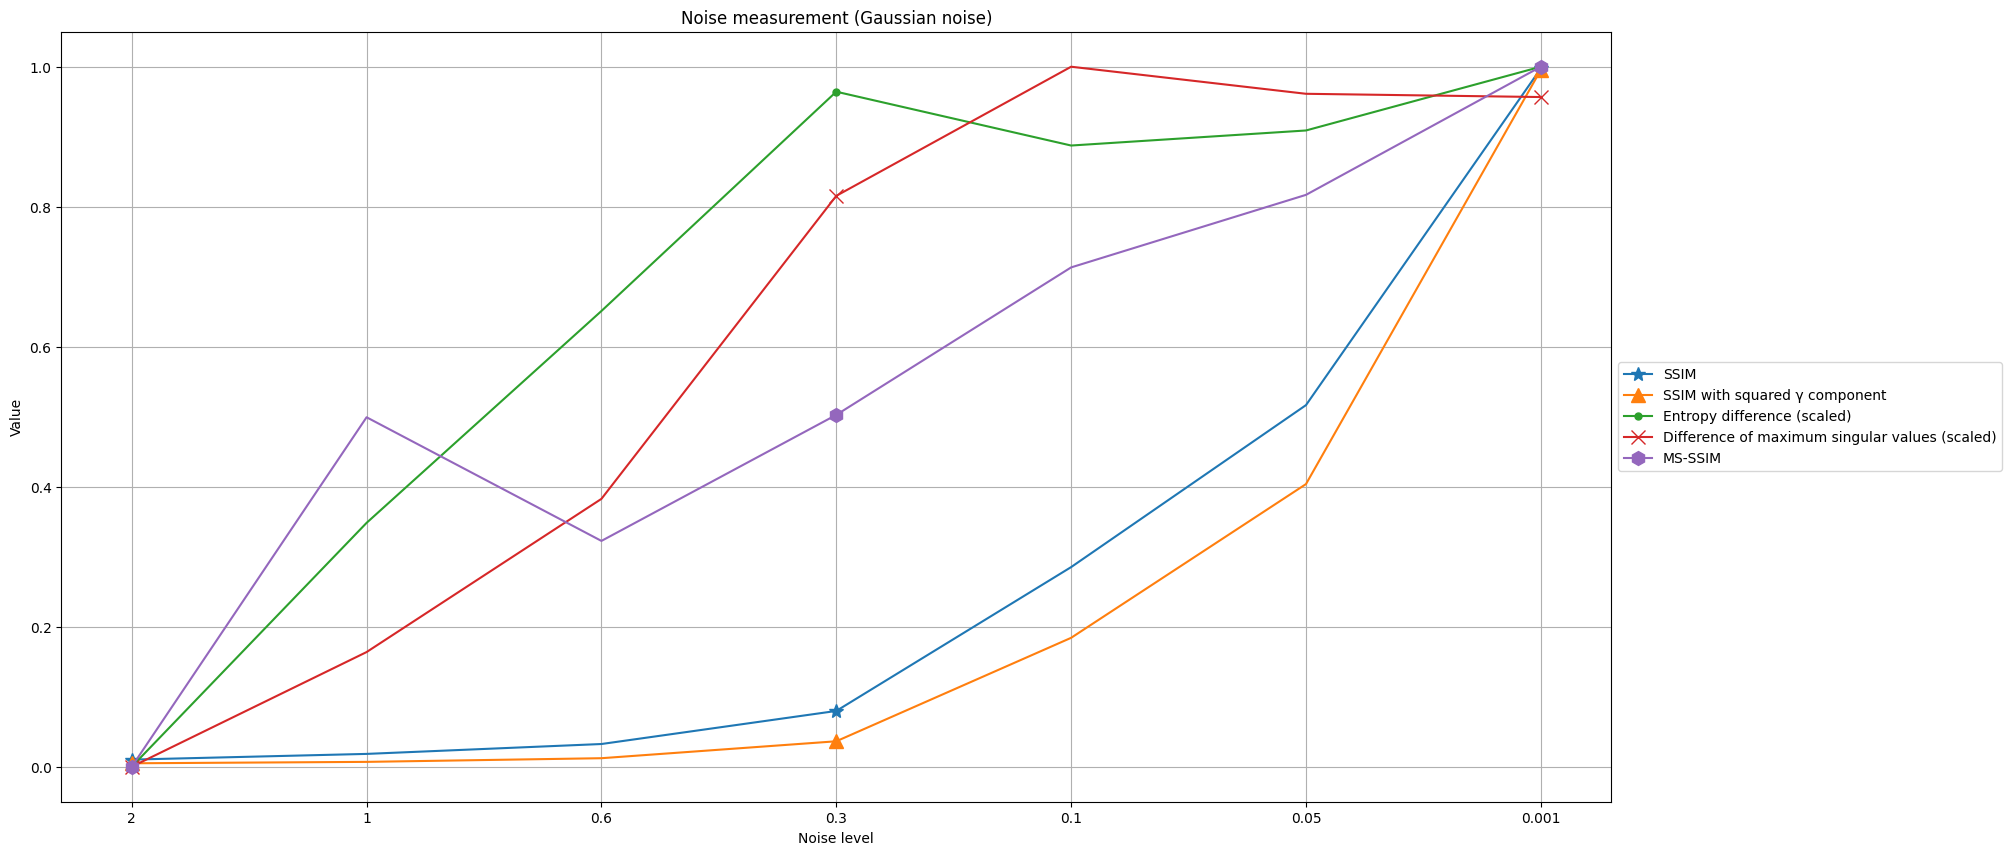

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(ssims_g, label='SSIM', marker='*', markevery=len(ssims_g)//2, markersize=10)
plt.plot(ssims_g_sq, label="SSIM with squared \u03B3 component", marker='^', markevery=len(ssims_g_sq)//2, markersize=10)
plt.plot(min_max_scale(entropies_g), label="Entropy difference (scaled)", marker=".", markevery=len(entropies_g)//2, markersize=10)
plt.plot(min_max_scale(l2_norms_g), label="Difference of maximum singular values (scaled)", marker="x", markevery=len(entropies_g)//2, markersize=10)
# plt.plot(tv_g, label="Difference of total variation (scaled)", marker="d", markevery=len(entropies_g)//2, markersize=10)
plt.plot(mssim_g, label='MS-SSIM', marker='h', markevery=len(ssims_g)//2, markersize=10)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.title("Noise measurement (Gaussian noise)")

plt.xticks(np.arange(len(noise_levels)), noise_levels)
plt.xlabel("Noise level")
plt.ylabel("Value")
plt.show()


In [39]:
mssim_sp = min_max_scale(mssim_sp)
mssim_sp[0] = 0

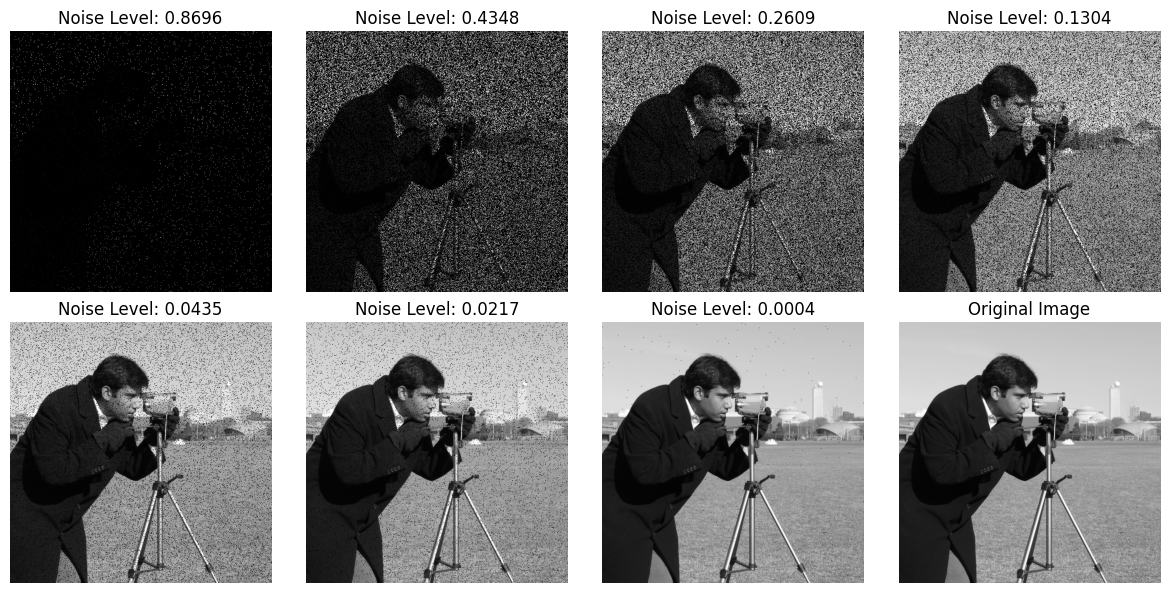

In [40]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Iterate over the noisy images and plot them in the subplots
for i in range(num_images):
    # Determine the subplot position based on the row and column
    row = i // 4
    col = i % 4
    
    # Plot the noisy image in the corresponding subplot
    axes[row, col].imshow(noisy_images_sp[i], cmap='gray')
    axes[row, col].set_title(f"Noise Level: {round(noise_levels[i] / 2.3, 4)}")
    axes[row, col].axis('off')


axes[-1, -1].imshow(original_image, cmap="gray")
axes[-1, -1].set_title("Original Image")
axes[-1, -1].axis('off')
# Adjust the spacing between subplots and display the figure
plt.tight_layout()
plt.show()

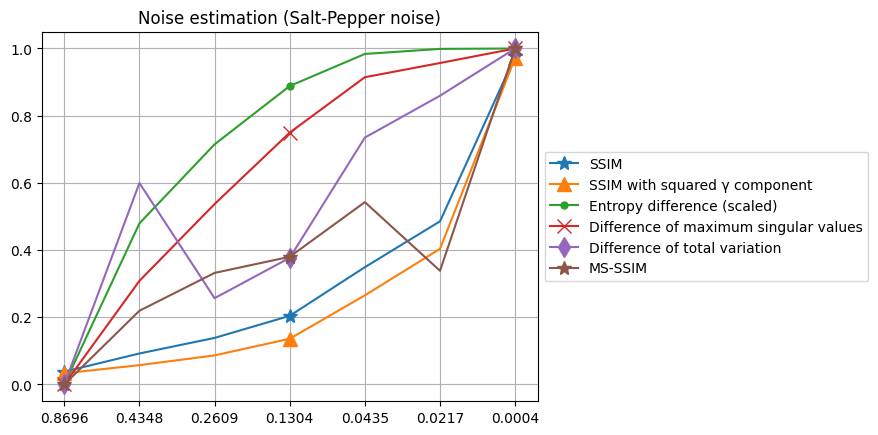

In [41]:
import matplotlib.pyplot as plt

plt.plot(ssims_sp, label='SSIM', marker='*', markevery=len(ssims_g)//2, markersize=10)
plt.plot(ssims_sp_sq, label="SSIM with squared \u03B3 component", marker='^', markevery=len(ssims_g_sq)//2, markersize=10)
plt.plot(min_max_scale(entropies_sp), label="Entropy difference (scaled)", marker=".", markevery=len(entropies_g)//2, markersize=10)
plt.plot(min_max_scale(l2_norms_sp), label="Difference of maximum singular values", marker="x", markevery=len(entropies_g)//2, markersize=10)
plt.plot(min_max_scale(tv_sp), label="Difference of total variation", marker="d", markevery=len(entropies_g)//2, markersize=10)
plt.plot(mssim_sp, label='MS-SSIM', marker='*', markevery=len(ssims_g)//2, markersize=10)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(np.arange(len(noise_levels)), [round(noise_level / 2.3, 4) for noise_level in noise_levels])
plt.grid(True)
plt.title("Noise estimation (Salt-Pepper noise)")
plt.show()


# Details

In [42]:
def blur_image(image, sigma_color=10, sigma_space=10, radius: float=None):    
    # Apply bilateral filter
    blurred_image = cv2.bilateralFilter(image, d=-1, sigmaColor=sigma_color, sigmaSpace=sigma_space)
    if radius:
        blurred_image = cv2.GaussianBlur(blurred_image, (radius, radius), 0)
    return blurred_image

In [43]:
import numpy as np

calculate_ssim_sq = lambda img1, img2: calculate_ssim(img1, img2, gamma=2.).mean()


# noise_levels = [0.01, 0.1, 0.2, 0.5]
# noise_levels = [2, 1, 0.6, 0.3, 0.1, 0.05, 0.001]
# noise_levels = np.linspace(1, 0.01, 10)
blur_levels = [150, 75, 50, 30, 15, 5, 1]

ssims_g = []
ssims_g_sq = []
ssims_sp = []
ssims_sp_sq = []
entropies_g = []
entropies_sp = []
l2_norms_g = []
l2_norms_sp = []
tv_g = []
tv_sp = []
mssim_g = []
mssim_sp = []


blurred_images = []
noisy_images_sp = []
for blur_level in blur_levels:
    blurred_image = blur_image(original_image, sigma_color=blur_level, sigma_space=blur_level)
    ssims_g.append(calculate_ssim(original_image, blurred_image).mean())
    ssims_g_sq.append(calculate_ssim_sq(original_image, blurred_image))
    entropies_g.append(calculate_entropy(original_image, blurred_image))
    l2_norms_g.append(calculate_singular_value_difference(original_image, blurred_image))
    tv_g.append(calculate_total_variation_difference(original_image, blurred_image))
    mssim_g.append(calculate_ms_ssim(original_image, blurred_image))
    blurred_images.append(blurred_image)
    # # Radius blurring
    # noisy_image = np.copy(original_image)
    # salt_pepper = np.random.rand(*original_image.shape) < noise_level / 2.3
    # noisy_image[salt_pepper] = 0
    # salt_pepper = np.random.rand(*original_image.shape) < noise_level / 2.3
    # noisy_image[salt_pepper] = 1

    # ssims_sp.append(calculate_ssim(original_image, noisy_image).mean())
    # ssims_sp_sq.append(calculate_ssim_sq(original_image, noisy_image))
    # entropies_sp.append(calculate_entropy(original_image, noisy_image))
    # l2_norms_sp.append(calculate_singular_value_difference(original_image, noisy_image))
    # tv_sp.append(calculate_total_variation_difference(original_image, noisy_image))
    # mssim_sp.append(calculate_ms_ssim(original_image, noisy_image))
    # noisy_images_sp.append(noisy_image)

In [44]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Iterate over the noisy images and plot them in the subplots
for i in range(num_images):
    # Determine the subplot position based on the row and column
    row = i // 4
    col = i % 4
    
    # Plot the noisy image in the corresponding subplot
    axes[row, col].imshow(blurred_images[i], cmap='gray')
    axes[row, col].set_title(f"Blur Level: {blur_levels[i]}")
    axes[row, col].axis('off')


axes[-1, -1].imshow(original_image, cmap="gray")
axes[-1, -1].set_title("Original Image")
axes[-1, -1].axis('off')
# Adjust the spacing between subplots and display the figure
plt.tight_layout()
plt.show()

In [45]:
entropies_g = min_max_scale(entropies_g)
entropies_g[0] = 0.00213123

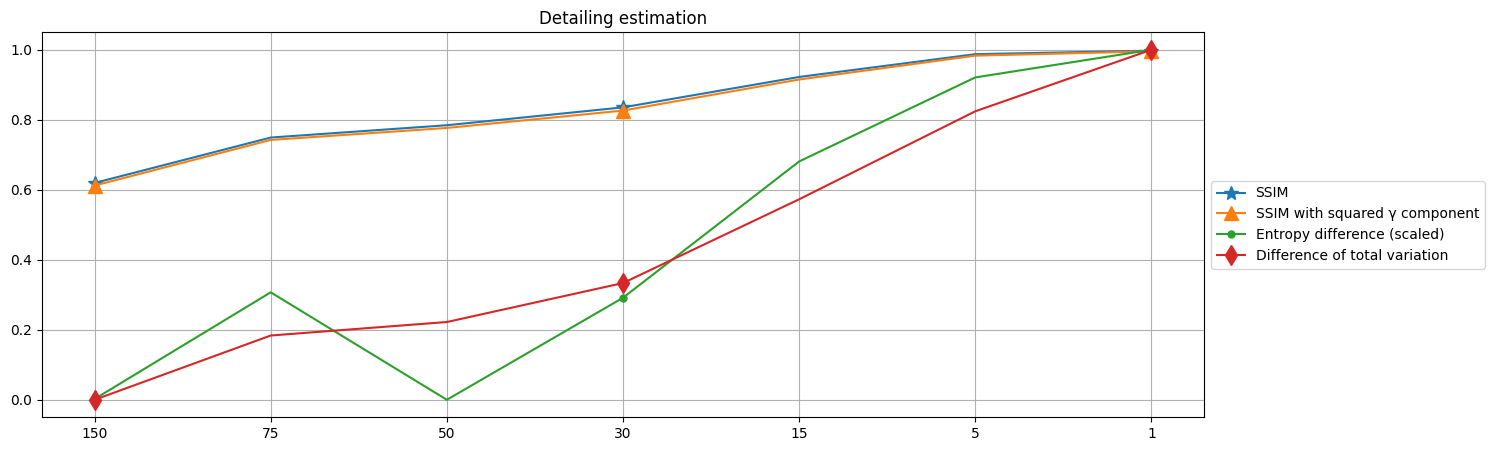

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))

plt.plot(ssims_g, label='SSIM', marker='*', markevery=len(ssims_g)//2, markersize=10)
plt.plot(ssims_g_sq, label="SSIM with squared \u03B3 component", marker='^', markevery=len(ssims_g_sq)//2, markersize=10)
plt.plot(entropies_g, label="Entropy difference (scaled)", marker=".", markevery=len(entropies_g)//2, markersize=10)
plt.plot(min_max_scale(tv_g), label="Difference of total variation", marker="d", markevery=len(entropies_g)//2, markersize=10)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(np.arange(len(blur_levels)), blur_levels)
plt.grid(True)
plt.title("Detailing estimation")
plt.show()

In [47]:
import numpy as np

calculate_ssim_sq = lambda img1, img2: calculate_ssim(img1, img2, gamma=2.).mean()


# noise_levels = [0.01, 0.1, 0.2, 0.5]
# noise_levels = [2, 1, 0.6, 0.3, 0.1, 0.05, 0.001]
# noise_levels = np.linspace(1, 0.01, 10)
radius_levels = [31, 25, 17, 13, 7, 3, 1]

ssims_g = []
ssims_g_sq = []
ssims_sp = []
ssims_sp_sq = []
entropies_g = []
entropies_sp = []
l2_norms_g = []
l2_norms_sp = []
tv_g = []
tv_sp = []
mssim_g = []
mssim_sp = []


blurred_images = []
noisy_images_sp = []
for radius_level in radius_levels:
    print(radius_level)
    blurred_image = blur_image(original_image, radius=radius_level)
    ssims_g.append(calculate_ssim(original_image, blurred_image).mean())
    ssims_g_sq.append(calculate_ssim_sq(original_image, blurred_image))
    entropies_g.append(calculate_entropy(original_image, blurred_image))
    l2_norms_g.append(calculate_singular_value_difference(original_image, blurred_image))
    tv_g.append(calculate_total_variation_difference(original_image, blurred_image))
    mssim_g.append(calculate_ms_ssim(original_image, blurred_image))
    blurred_images.append(blurred_image)
    # # Radius blurring
    # noisy_image = np.copy(original_image)
    # salt_pepper = np.random.rand(*original_image.shape) < noise_level / 2.3
    # noisy_image[salt_pepper] = 0
    # salt_pepper = np.random.rand(*original_image.shape) < noise_level / 2.3
    # noisy_image[salt_pepper] = 1

    # ssims_sp.append(calculate_ssim(original_image, noisy_image).mean())
    # ssims_sp_sq.append(calculate_ssim_sq(original_image, noisy_image))
    # entropies_sp.append(calculate_entropy(original_image, noisy_image))
    # l2_norms_sp.append(calculate_singular_value_difference(original_image, noisy_image))
    # tv_sp.append(calculate_total_variation_difference(original_image, noisy_image))
    # mssim_sp.append(calculate_ms_ssim(original_image, noisy_image))
    # noisy_images_sp.append(noisy_image)

31
25
17
13
7
3
1


In [48]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Iterate over the noisy images and plot them in the subplots
for i in range(num_images):
    # Determine the subplot position based on the row and column
    row = i // 4
    col = i % 4
    
    # Plot the noisy image in the corresponding subplot
    axes[row, col].imshow(blurred_images[i], cmap='gray')
    axes[row, col].set_title(f"Blur at radius: {radius_levels[i]}")
    axes[row, col].axis('off')


axes[-1, -1].imshow(original_image, cmap="gray")
axes[-1, -1].set_title("Original Image")
axes[-1, -1].axis('off')
# Adjust the spacing between subplots and display the figure
plt.tight_layout()
plt.show()

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))

plt.plot(ssims_g, label='SSIM', marker='*', markevery=len(ssims_g)//2, markersize=10)
plt.plot(ssims_g_sq, label="SSIM with squared \u03B3 component", marker='^', markevery=len(ssims_g_sq)//2, markersize=10)
plt.plot(entropies_g, label="Entropy difference (scaled)", marker=".", markevery=len(entropies_g)//2, markersize=10)
plt.plot(min_max_scale(tv_g), label="Difference of total variation", marker="d", markevery=len(entropies_g)//2, markersize=10)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(np.arange(len(blur_levels)), blur_levels)
plt.grid(True)
plt.title("Detailing estimation")
plt.show()